<a href="https://colab.research.google.com/github/lhiwi/complaint-rag-chatbot/blob/task1-eda/notebooks/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Standard libraries
import os
import re

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm.auto import tqdm
tqdm.pandas()



In [ ]:
# load the data
RAW_PATH = '/content/drive/MyDrive/Copy of complaints.csv'

# Read file
df = pd.read_csv(RAW_PATH)

# Sanity-check
print(f"Loaded {df.shape[0]} rows × {df.shape[1]} cols from {RAW_PATH}")
df.head(3)



/tmp/ipython-input-4-4267895351.py:5: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_PATH)


Loaded 9609797 rows × 18 cols from /content/drive/MyDrive/Copy of complaints.csv


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689


In [ ]:
# the five products of interest
TARGET_PRODUCTS = [
    'Credit card',
    'Personal loan',
    'Buy now pay later',
    'Savings account',
    'Money transfers'
]

# Text-cleaning function
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r'http\S+', ' ', txt)
    txt = re.sub(r'writing to file a complaint', ' ', txt)
    txt = re.sub(r'[^a-z0-9\s]', ' ', txt)
    return re.sub(r'\s+', ' ', txt).strip()


In [ ]:
# sample data
usecols = ['Product', 'Consumer complaint narrative']

df_sample = pd.read_csv(RAW_PATH, usecols=usecols, nrows=200_000)

print(f"Sample loaded: {df_sample.shape[0]} rows")
df_sample.head()

Sample loaded: 200000 rows


,Product,Consumer complaint narrative
0,Credit reporting or other personal consumer re...,NaN
1,Debt collection,NaN
2,Credit reporting or other personal consumer re...,NaN
3,Credit reporting or other personal consumer re...,NaN
4,Credit reporting or other personal consumer re...,NaN


In [ ]:
# Drop empty narratives in the sample
df_sample = df_sample[df_sample['Consumer complaint narrative'].notna()
                      & df_sample['Consumer complaint narrative'].str.strip().ne('')]

df_sample.head()


,Product,Consumer complaint narrative
76,Credit reporting or other personal consumer re...,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Apt XX...
359,Credit reporting or other personal consumer re...,Subject : Dispute of Unauthorized Hard Inquiri...
11499,Mortgage,I signed a purchase agreement with Lennar Corp...
11973,Credit reporting or other personal consumer re...,"After checking my report, I found numerous acc..."
12237,Credit card,A XXXX XXXX card was opened under my name by a...


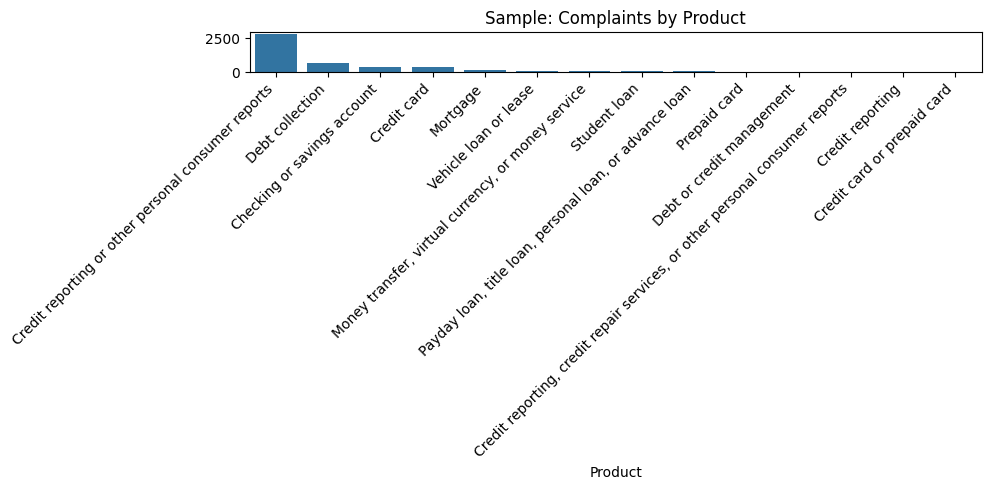

In [ ]:
# Product distribution
prod_counts = df_sample['Product'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=prod_counts.index, y=prod_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Sample: Complaints by Product')
plt.tight_layout()
plt.show()

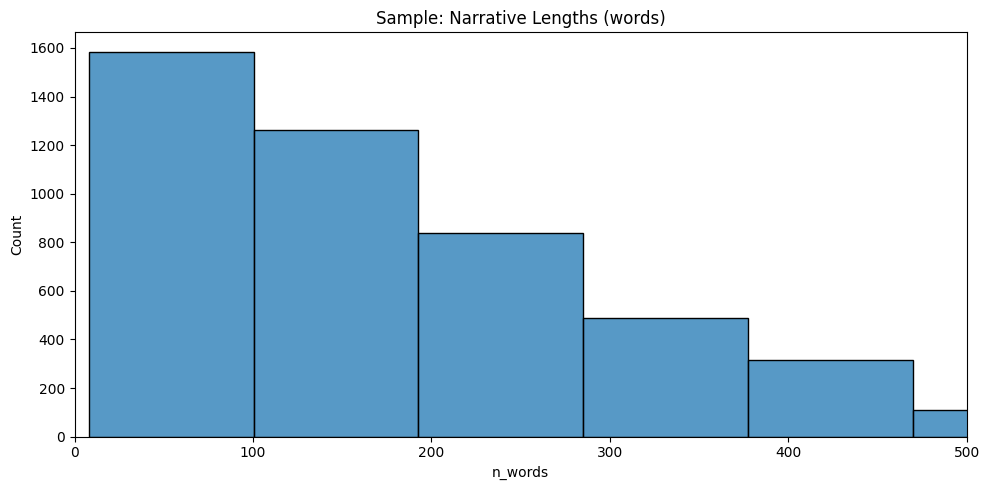

In [ ]:
# Narrative lengths
df_sample['n_words'] = df_sample['Consumer complaint narrative'].str.split().apply(len)
plt.figure(figsize=(10,5))
sns.histplot(df_sample['n_words'], bins=50)
plt.xlim(0,500)
plt.title('Sample: Narrative Lengths (words)')
plt.tight_layout()
plt.show()

In [ ]:
# to save filtered data
OUT_PATH = 'data/filtered_complaints.csv'

In [ ]:
# Check the output directory exists
out_dir = os.path.dirname(OUT_PATH)  # this is 'data'
os.makedirs(out_dir, exist_ok=True)

# If you’d like to start fresh, delete any existing file
if os.path.exists(OUT_PATH):
    os.remove(OUT_PATH)

#  Read & process in chunks
reader = pd.read_csv(
    RAW_PATH,
    usecols=['Product', 'Consumer complaint narrative'],
    chunksize=500_000,
    iterator=True
)

for i, chunk in enumerate(tqdm(reader, desc='Processing chunks')):
    # 5.3.1 Filter to target products & non-empty narratives
    mask = (
        chunk['Product'].isin(TARGET_PRODUCTS)
        & chunk['Consumer complaint narrative'].notna()
        & chunk['Consumer complaint narrative'].str.strip().ne('')
    )
    df_chunk = chunk.loc[mask].copy()

    #  Clean text
    df_chunk['clean_narrative'] = df_chunk['Consumer complaint narrative']\
        .progress_apply(clean_text)

    #  Write out header only on first chunk
    df_chunk.to_csv(
        OUT_PATH,
        index=False,
        mode='w' if i == 0 else 'a',
        header=(i == 0)
    )

print(f" cleaned data saved to {OUT_PATH}")


Processing chunks: 0it [00:00, ?it/s]

  0%|          | 0/1311 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/4313 [00:00<?, ?it/s]

  0%|          | 0/4650 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]

  0%|          | 0/4364 [00:00<?, ?it/s]

  0%|          | 0/4757 [00:00<?, ?it/s]

  0%|          | 0/4403 [00:00<?, ?it/s]

  0%|          | 0/2513 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/2187 [00:00<?, ?it/s]

  0%|          | 0/1602 [00:00<?, ?it/s]

  0%|          | 0/8021 [00:00<?, ?it/s]

  0%|          | 0/5186 [00:00<?, ?it/s]

  0%|          | 0/3839 [00:00<?, ?it/s]

  0%|          | 0/6263 [00:00<?, ?it/s]

  0%|          | 0/8945 [00:00<?, ?it/s]

  0%|          | 0/7856 [00:00<?, ?it/s]

  0%|          | 0/1136 [00:00<?, ?it/s]

 cleaned data saved to data/filtered_complaints.csv


In [ ]:
# Sanity-Check the Output
df_filt = pd.read_csv(OUT_PATH, nrows=5)
print(df_filt.shape)
df_filt.head()


(5, 3)


,Product,Consumer complaint narrative,clean_narrative
0,Credit card,A XXXX XXXX card was opened under my name by a...,a xxxx xxxx card was opened under my name by a...
1,Credit card,"Dear CFPB, I have a secured credit card with c...",dear cfpb i have a secured credit card with ci...
2,Credit card,I have a Citi rewards cards. The credit balanc...,i have a citi rewards cards the credit balance...
3,Credit card,b'I am writing to dispute the following charge...,b i am writing to dispute the following charge...
4,Credit card,"Although the account had been deemed closed, I...",although the account had been deemed closed i ...
